## Exercise Sheet 1: Recurrent Models

Compare Vanilla Recurrent Neural Networks (RNN) with Long-Short Term Networks (LSTM). Implement a vanilla RNN and LSTM from scratch. 

In [69]:
import json
import os
import time
import math
import sys
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.functional as F

# import RNN from torch
from torch.nn import RNN

import matplotlib.pyplot as plt
%matplotlib inline

# set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set paths
data_path = './data/'
model_path = './model/'
results_path = './results/'

# make directories if they don't exist
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(results_path):
    os.makedirs(results_path)


# Data
p1 = [5, 10, 15, 20]
p2_acc_rnn = []
p3_acc_lstm = []

# Hyperparameters 
config = {
    "input_length": 12,
    "input_dim": 1,
    "num_classes": 10,
    "num_hidden": 128,
    "batch_size": 128,
    "learning_rate": 0.001,
    "train_steps": 1000,
    "test_steps": 100,
    "max_norm": 1.0
}

# save config
with open(model_path + 'config.json', 'w') as file:
    json.dump(config, file)

### Task 1: Toy Problem: Palindrome Numbers

Use a  a recurrent neural network to predict the next digit of the palindrome
at every timestep. This can become difficult for very long sequences since the network has to memorise information from very far away earlier timesteps. Goal is to study the memoization capability of recurrent networks.

In [70]:
class PalindromeDataset(data.Dataset):
    """ Randomly generates palindromes of a given length. 
        The input is the first N-1 digits of the palindrome, the target is the last digit.
        For short palindromes, the number of possible palindromes is limited.
    """
    def __init__(self, seq_length):
        self.seq_length = seq_length

    def __len__(self):
        # Number of possible palindroms can be very big:
        # (10**(seq_length/2) or (10**((seq_length+1)/2)
        # Therefore we return the maximum integer value
        return sys.maxsize

    def __getitem__(self, idx):
        # Keep last digit as target label. Note: one-hot encoding for inputs is
        # more suitable for training, but this also works.
        full_palindrome = self.generate_palindrome()
        # Split palindrome into inputs (N-1 digits) and target (1 digit)
        return full_palindrome[0:-1], int(full_palindrome[-1])

    def generate_palindrome(self):
        # Generates a single, random palindrome number of 'length' digits.
        left = [np.random.randint(0, 10) for _ in range(math.ceil(self.seq_length / 2))]
        left = np.asarray(left, dtype=np.float32)
        right = np.flip(left, 0) if self.seq_length % 2 == 0 else np.flip(left[:-1], 0)
        return np.concatenate((left, right))


In [71]:
class VanillaRNN(nn.Module):

    def __init__(
        self, seq_length, input_dim, num_hidden, num_classes, batch_size, device=None):
        super(VanillaRNN, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size

        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.device = device

        # Define the RNN layer
        self.hidden_state = torch.zeros(self.batch_size, self.num_hidden)
        self.W_hx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))      # input to hidden
        self.W_hh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))     # hidden to hidden
        self.B_h = nn.Parameter(torch.Tensor(self.num_hidden))                       # hidden bias
        # Define the output layer
        self.W_ph = nn.Parameter(torch.Tensor(self.num_hidden, self.num_classes))    # hidden to output
        self.B_y = nn.Parameter(torch.Tensor(self.num_classes))                      # output bias

        # Initialize weights
        self.init_weights()
    
    def forward(self, x):
        # Initialize hidden state
        h_t = torch.zeros(self.num_hidden)
            
        for t in range(self.seq_length): # iterate over the time steps
            x_t = x[:, t].view(128,-1)
            h_t = torch.tanh(x_t @ self.W_hx + h_t @ self.W_hh + self.B_h)
            
        output = h_t @ self.W_ph + self.B_y
        y = torch.softmax(output, dim=1)
        return y

    def init_weights(self):
        """ Keep weights in a similar range to avoid 
            gradients vanishing or exploding.
        """
        # Initialize weights
        nn.init.xavier_normal_(self.W_hx)
        nn.init.xavier_normal_(self.W_hh)
        nn.init.xavier_normal_(self.W_ph)
        nn.init.zeros_(self.B_h)
        nn.init.zeros_(self.B_y)
    
    def set_grad(self, requires_grad):
        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

In [72]:
def compute_accuracy(outputs, targets):
    """ Compute the accuracy of the model's predictions."""
    # Compute accuracy of outputs compared to targets
    _, predicted = torch.max(outputs, 1)
    correct = predicted.eq(targets)
    return 100 * correct.sum().item() / targets.size(0)

In [73]:

def train(config:json, input_length=5, type='RNN', device=None):
    """ Train the model on the training set.
        Returns the trained model, losses and accuracies.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if input_length == 0:
        input_length = config['input_length']

    # Initialize the model that we are going to use
    if type == 'RNN':
        model = VanillaRNN(input_length, config['input_dim'], config['num_hidden'], config['num_classes'], config['batch_size'])
    elif type == 'LSTM':
        model = LSTM(input_length, config['input_dim'], config['num_hidden'], config['num_classes'], config['batch_size'])
    else:
        raise ValueError('Model type not supported')
    
    model.to(device)
    model.train()

    # Initialize the dataset and data loader (note the +1)
    dataset = PalindromeDataset(input_length + 1)
    data_loader = data.DataLoader(dataset, config['batch_size'], num_workers=0)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'])

    # Train the model
    losses = []
    accuracies = []
    loss = 0.0

    for i, (inputs, targets) in enumerate(data_loader, 0):

        # Only for time measurement of step through network
        t1 = time.time()
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])

        loss += loss.item()
        accuracy = 0.0

        # Print statistics
        if i % 10 == 0:
            # Just for time measurement
            t2 = time.time()
            # print accuracy/loss here
            accuracy = compute_accuracy(outputs, targets)
            accuracies.append(accuracy)
            print('[step: %5d] loss: %.4f acc: %.4f time: %5d' %
                          (i, loss / 10, accuracy, t2-t1 / 10))
            losses.append(loss.detach().numpy() / 10)
            loss = 0.0

        if i == config['train_steps']:
            # If you receive a PyTorch data-loader error, check this bug report:
            # https://github.com/pytorch/pytorch/pull/9655
            break
        
    print('Finished Training')
    return model, losses, accuracies


def test(model, config:json, input_length=5, device=None):
    """ Test the model on the test set.
        Returns the accuracies.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if input_length == 0:
        input_length = config['input_length']

    # Initialize the dataset and data loader (leave the +1)
    dataset = PalindromeDataset(input_length+1)
    data_loader = data.DataLoader(dataset, config['batch_size'], num_workers=0)

    model.to(device)
    model.eval()

    # Test the model
    accuracies = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader, 0):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            accuracy = 0.0 
            if i % 10 == 0:
                accuracy = compute_accuracy(outputs, targets)
                accuracies.append(accuracy)
                print('Accuracy: %.4f' % accuracy)

            if i == config['test_steps']:
                break
            
    print('Finished Testing')
    return accuracies


In [74]:
# Load the configuration
with open(model_path + 'config.json', 'r') as file:
    config = json.load(file)

In [75]:
def plot_loss(losses, title='Training Loss', path=None):
    """ Plot the losses of the model."""
    if path is None:
        path = results_path + 'training_loss.png'
    plt.plot(losses)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title(title)
    plt.savefig(path)
    plt.show()

def plot_accuracy(accuracies, title='Training Accuracy', path=None):
    """ Plot the accuracies of the model."""
    if path is None:
        path = results_path + 'training_accuracy.png'
    plt.plot(accuracies)
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.savefig(path)
    plt.show()


#### Train and evaluate model on Palindromes with length N = 11

In [76]:
# Train the model on T=5
model, losses, accuracies = train(config, input_length=p1[0], type='RNN', device=device)
# Add accuracies
p2_acc_rnn.append(np.mean(accuracies))

/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_62089/1086367360.py:51: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:     0] loss: 0.4624 acc: 6.2500 time: 1547309973
[step:    10] loss: 0.4354 acc: 28.1250 time: 1547309973
[step:    20] loss: 0.4309 acc: 28.9062 time: 1547309973
[step:    30] loss: 0.4148 acc: 45.3125 time: 1547309973
[step:    40] loss: 0.4112 acc: 42.9688 time: 1547309973
[step:    50] loss: 0.4035 acc: 48.4375 time: 1547309973
[step:    60] loss: 0.3970 acc: 50.0000 time: 1547309973
[step:    70] loss: 0.3961 acc: 50.7812 time: 1547309973
[step:    80] loss: 0.3892 acc: 53.9062 time: 1547309973
[step:    90] loss: 0.3767 acc: 59.3750 time: 1547309973
[step:   100] loss: 0.3607 acc: 74.2188 time: 1547309973
[step:   110] loss: 0.3587 acc: 82.8125 time: 1547309973
[step:   120] loss: 0.3938 acc: 47.6562 time: 1547309973
[step:   130] loss: 0.3749 acc: 57.8125 time: 1547309973
[step:   140] loss: 0.3586 acc: 72.6562 time: 1547309973
[step:   150] loss: 0.3642 acc: 68.7500 time: 1547309973
[step:   160] loss: 0.3342 acc: 84.3750 time: 1547309973
[step:   170] loss: 0.3557 acc: 

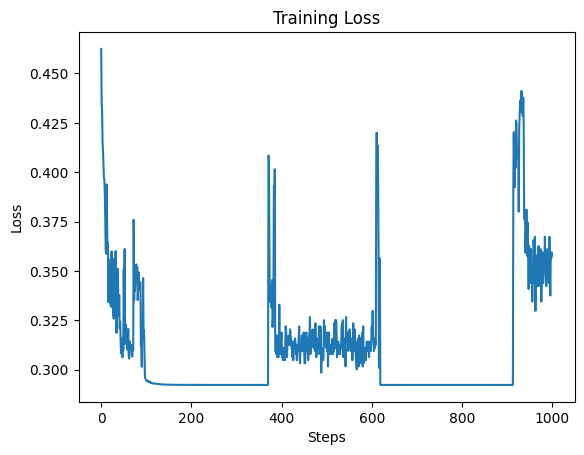

In [77]:
# Plot the losses
plot_loss(losses, title='Training Loss', path=results_path + 'training_loss_5_rnn.png')

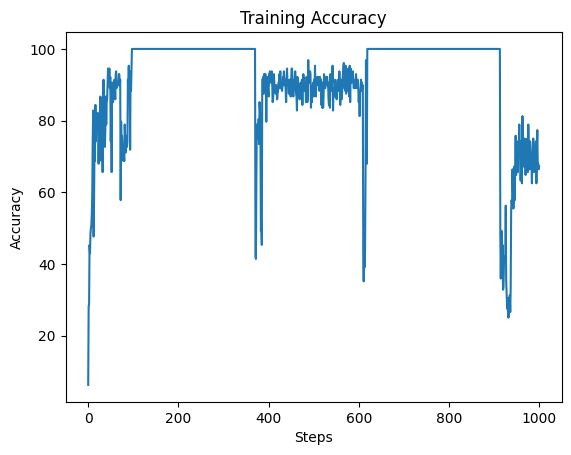

In [78]:
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_5_rnn.png')

In [79]:
# Test the model
test_accuracies = test(model, input_length=p1[0], config=config, device=device)

Accuracy: 65.6250
Accuracy: 65.6250
Accuracy: 67.1875
Accuracy: 75.0000
Accuracy: 70.3125
Accuracy: 65.6250
Accuracy: 71.8750
Accuracy: 66.4062
Accuracy: 68.7500
Accuracy: 65.6250
Accuracy: 79.6875
Finished Testing


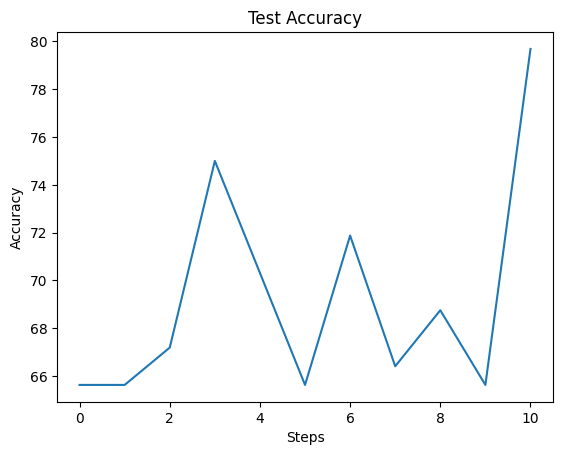

Average test accuracy: 69.25%


In [80]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_5_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

### Task 2: Vanilla RNN in PyTorch

[step:     0] loss: 0.4602 acc: 11.7188 time: 1547309995
[step:    10] loss: 0.4387 acc: 28.1250 time: 1547309995
[step:    20] loss: 0.4446 acc: 21.8750 time: 1547309995
[step:    30] loss: 0.4381 acc: 23.4375 time: 1547309995
[step:    40] loss: 0.4292 acc: 32.0312 time: 1547309995
[step:    50] loss: 0.4125 acc: 42.9688 time: 1547309995


/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_62089/1086367360.py:51: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    60] loss: 0.4090 acc: 42.1875 time: 1547309995
[step:    70] loss: 0.4204 acc: 32.0312 time: 1547309995
[step:    80] loss: 0.3964 acc: 46.0938 time: 1547309995
[step:    90] loss: 0.3871 acc: 56.2500 time: 1547309995
[step:   100] loss: 0.4118 acc: 44.5312 time: 1547309995
[step:   110] loss: 0.3711 acc: 62.5000 time: 1547309995
[step:   120] loss: 0.3827 acc: 57.0312 time: 1547309995
[step:   130] loss: 0.3653 acc: 72.6562 time: 1547309995
[step:   140] loss: 0.3810 acc: 57.8125 time: 1547309995
[step:   150] loss: 0.3605 acc: 68.7500 time: 1547309995
[step:   160] loss: 0.3960 acc: 45.3125 time: 1547309995
[step:   170] loss: 0.3578 acc: 71.0938 time: 1547309995
[step:   180] loss: 0.3758 acc: 62.5000 time: 1547309995
[step:   190] loss: 0.3560 acc: 75.7812 time: 1547309995
[step:   200] loss: 0.3914 acc: 50.0000 time: 1547309995
[step:   210] loss: 0.3555 acc: 74.2188 time: 1547309995
[step:   220] loss: 0.3591 acc: 70.3125 time: 1547309995
[step:   230] loss: 0.3502 acc:

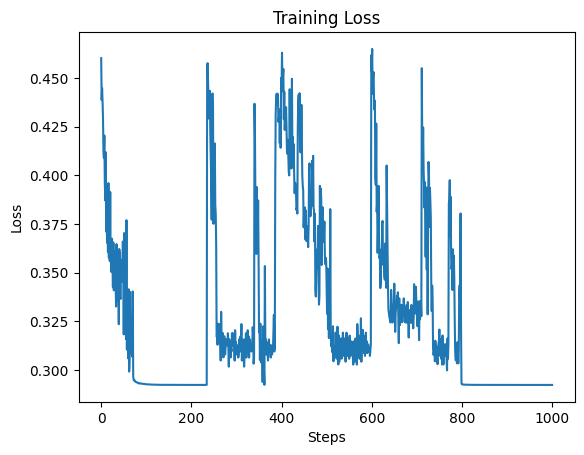

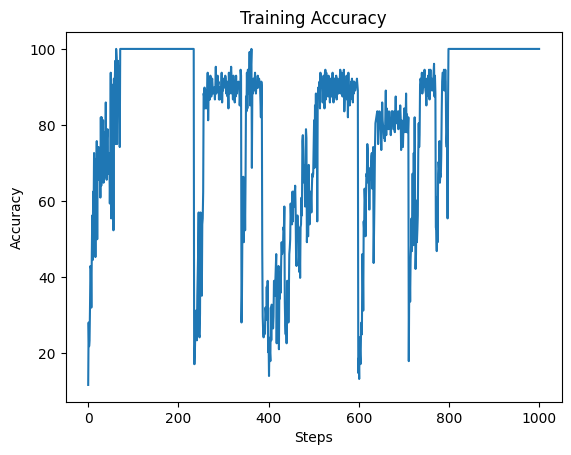

In [81]:
# Train the model on T=10
model, losses, accuracies = train(config, input_length=p1[1], type='RNN', device=device)
# Add accuracies
p2_acc_rnn.append(np.mean(accuracies))

# Plot the losses
plot_loss(losses, title='Training Loss', path=results_path + 'training_loss_10_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_10_rnn.png')

Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Finished Testing


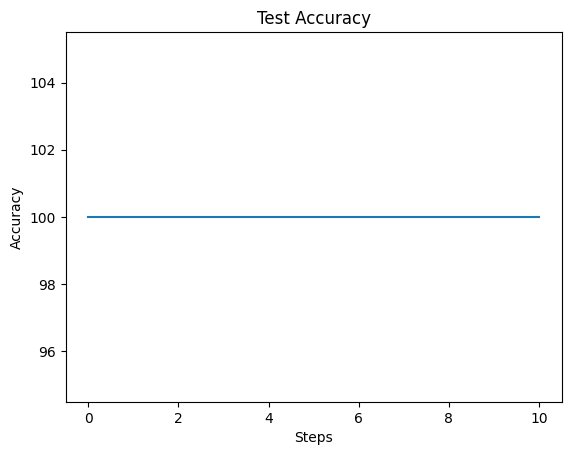

In [82]:
# Test the model
test_accuracies = test(model, input_length=p1[1], config=config, device=device)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_10_rnn.png')

[step:     0] loss: 0.4577 acc: 14.8438 time: 1547310028


/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_62089/1086367360.py:51: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    10] loss: 0.4626 acc: 12.5000 time: 1547310028
[step:    20] loss: 0.4592 acc: 12.5000 time: 1547310028
[step:    30] loss: 0.4629 acc: 7.8125 time: 1547310028
[step:    40] loss: 0.4540 acc: 14.8438 time: 1547310029
[step:    50] loss: 0.4473 acc: 19.5312 time: 1547310029
[step:    60] loss: 0.4452 acc: 22.6562 time: 1547310029
[step:    70] loss: 0.4416 acc: 30.4688 time: 1547310029
[step:    80] loss: 0.4246 acc: 43.7500 time: 1547310029
[step:    90] loss: 0.4567 acc: 10.1562 time: 1547310029
[step:   100] loss: 0.4243 acc: 40.6250 time: 1547310029
[step:   110] loss: 0.4590 acc: 12.5000 time: 1547310029
[step:   120] loss: 0.4485 acc: 15.6250 time: 1547310029
[step:   130] loss: 0.4323 acc: 25.7812 time: 1547310029
[step:   140] loss: 0.4243 acc: 28.9062 time: 1547310029
[step:   150] loss: 0.4006 acc: 44.5312 time: 1547310029
[step:   160] loss: 0.3942 acc: 58.5938 time: 1547310029
[step:   170] loss: 0.4139 acc: 41.4062 time: 1547310029
[step:   180] loss: 0.4295 acc: 

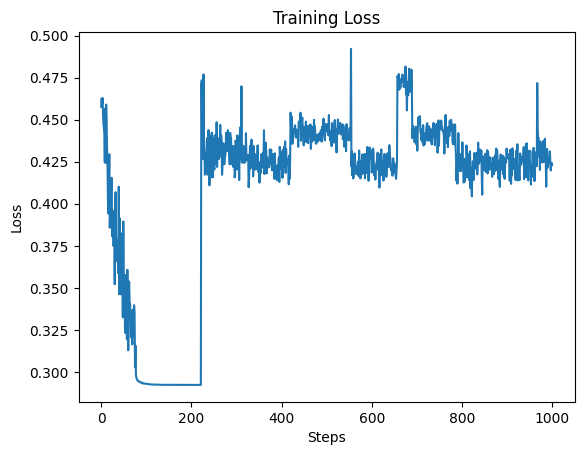

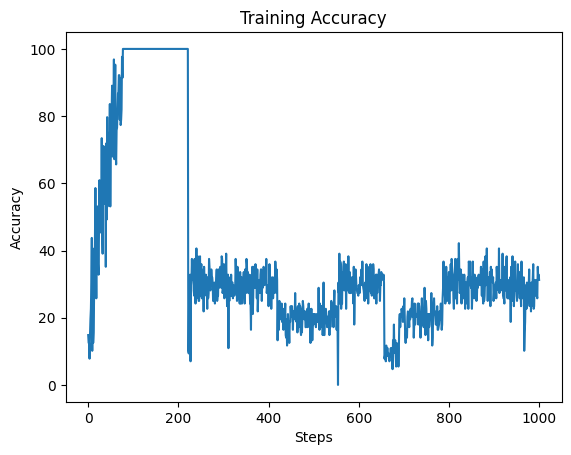

In [83]:
# Train the model on T=15
model, losses, accuracies = train(config, input_length=p1[2], type='RNN', device=device)
# Add accuracies
p2_acc_rnn.append(np.mean(accuracies))

# Plot the losses
plot_loss(losses, title='Training Loss', path=results_path + 'training_loss_15_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_15_rnn.png')

Accuracy: 31.2500
Accuracy: 25.0000
Accuracy: 31.2500
Accuracy: 26.5625
Accuracy: 32.8125
Accuracy: 32.8125
Accuracy: 29.6875
Accuracy: 23.4375
Accuracy: 32.0312
Accuracy: 34.3750
Accuracy: 27.3438
Finished Testing


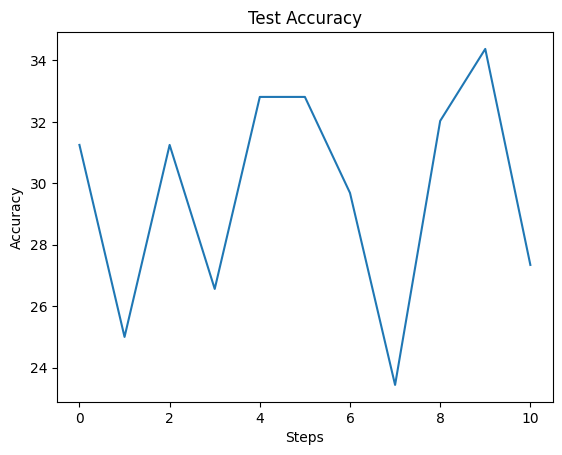

In [84]:
# Test the model
test_accuracies = test(model, input_length=p1[2], config=config, device=device)

# plot the test accuracies 
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_15_rnn.png')

[step:     0] loss: 0.4608 acc: 10.9375 time: 1547310071


/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_62089/1086367360.py:51: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    10] loss: 0.4606 acc: 10.1562 time: 1547310071
[step:    20] loss: 0.4595 acc: 13.2812 time: 1547310071
[step:    30] loss: 0.4634 acc: 6.2500 time: 1547310072
[step:    40] loss: 0.4594 acc: 11.7188 time: 1547310072
[step:    50] loss: 0.4608 acc: 14.0625 time: 1547310072
[step:    60] loss: 0.4641 acc: 7.8125 time: 1547310072
[step:    70] loss: 0.4615 acc: 10.9375 time: 1547310072
[step:    80] loss: 0.4607 acc: 9.3750 time: 1547310072
[step:    90] loss: 0.4653 acc: 7.0312 time: 1547310072
[step:   100] loss: 0.4621 acc: 7.0312 time: 1547310072
[step:   110] loss: 0.4605 acc: 7.8125 time: 1547310072
[step:   120] loss: 0.4618 acc: 7.0312 time: 1547310072
[step:   130] loss: 0.4614 acc: 7.0312 time: 1547310072
[step:   140] loss: 0.4602 acc: 9.3750 time: 1547310072
[step:   150] loss: 0.4604 acc: 14.0625 time: 1547310072
[step:   160] loss: 0.4602 acc: 10.1562 time: 1547310072
[step:   170] loss: 0.4596 acc: 12.5000 time: 1547310072
[step:   180] loss: 0.4600 acc: 11.7188 

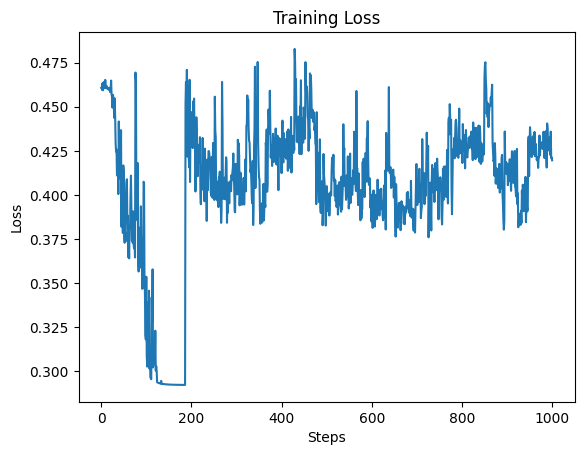

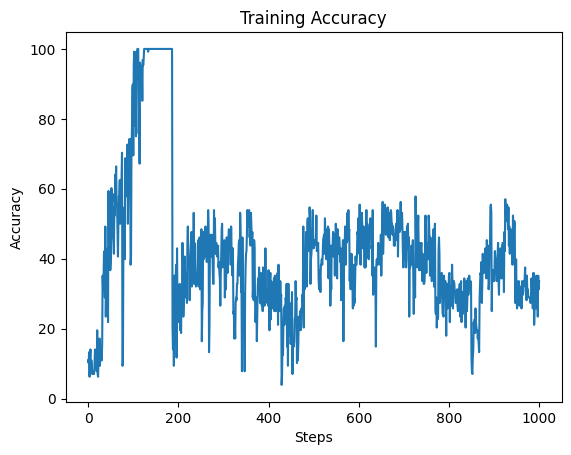

In [85]:
# Train the model on T=20
model, losses, accuracies = train(config, input_length=p1[3], type='RNN', device=device)
# Add accuracies
p2_acc_rnn.append(np.mean(accuracies))

# Plot the losses
plot_loss(losses, title='Training Loss', path=results_path + 'training_loss_20_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_20_rnn.png') 

Accuracy: 35.1562
Accuracy: 39.0625
Accuracy: 32.0312
Accuracy: 29.6875
Accuracy: 23.4375
Accuracy: 27.3438
Accuracy: 25.0000
Accuracy: 29.6875
Accuracy: 25.7812
Accuracy: 37.5000
Accuracy: 35.9375
Finished Testing


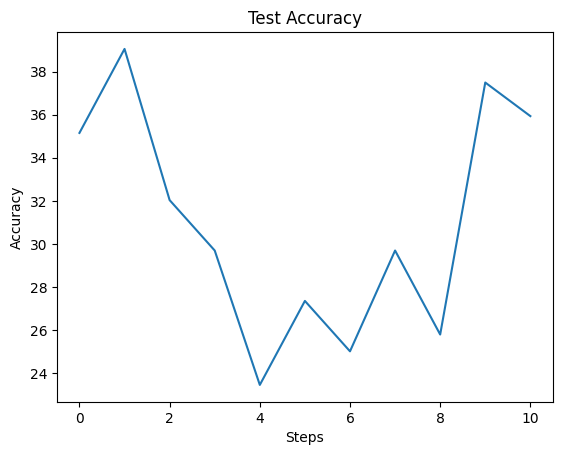

In [86]:
# Test the model
test_accuracies = test(model, input_length=p1[3], config=config, device=device)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_20_rnn.png')

### Task 3: Long-Short Term Network (LSTM) in PyTorch 

In [87]:
class LSTM(nn.Module):

    def __init__(self, seq_length, input_dim, num_hidden, num_classes, batch_size=128, device=None):
        super(LSTM, self).__init__()

        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size

        if device is None:
          device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.device = device

        # Hidden Layer
        self.W_gx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_gh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_g = nn.Parameter(torch.Tensor(self.num_hidden))

        # Cell State
        # (1) Input gate
        self.W_ix = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_ih = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_i = nn.Parameter(torch.Tensor(self.num_hidden))

        # (2) Forget gate
        self.W_fx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_fh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_f = nn.Parameter(torch.Tensor(self.num_hidden))

        # (3) Output gate
        self.W_ox = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_oh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_o = nn.Parameter(torch.Tensor(self.num_hidden))

        # Output Layer
        self.W_ph = nn.Parameter(torch.Tensor(self.num_hidden, self.num_classes))
        self.B_y = nn.Parameter(torch.Tensor(self.num_classes))

        # Initialize weights
        self.init_weights()


    def forward(self, x):
        # Initialize hidden state and cell state
        h_t = torch.zeros(self.batch_size, self.self.num_hidden, device=self.device)
        c_t = torch.zeros(self.batch_size, self.self.num_hidden, device=self.device)

        for t in range(self.seq_length):
            x_t = x[:, t].view(self.batch_size, -1)

            # Compute the hidden state
            g_t = torch.tanh(x_t @ self.W_gx + h_t @ self.W_gh + self.B_g)
            i_t = torch.sigmoid(x_t @ self.W_ix + h_t @ self.W_ih + self.B_i)
            f_t = torch.sigmoid(x_t @ self.W_fx + h_t @ self.W_fh + self.B_f)
            o_t = torch.sigmoid(x_t @ self.W_ox + h_t @ self.W_oh + self.B_o)

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

        # Compute the output
        output = h_t @ self.W_ph + self.B_y
        y = torch.softmax(output, dim=1)
        return y
    
    def init_weights(self):
        """ Keep weights in a similar range to avoid 
            gradients vanishing or exploding.
        """
        # Initialize weights
        nn.init.xavier_normal_(self.W_gx)
        nn.init.xavier_normal_(self.W_gh)
        nn.init.xavier_normal_(self.W_ix)
        nn.init.xavier_normal_(self.W_ih)
        nn.init.xavier_normal_(self.W_fx)
        nn.init.xavier_normal_(self.W_fh)
        nn.init.xavier_normal_(self.W_ox)
        nn.init.xavier_normal_(self.W_oh)
        nn.init.xavier_normal_(self.W_ph)
        nn.init.zeros_(self.B_g)
        nn.init.zeros_(self.B_i)
        nn.init.zeros_(self.B_f)
        nn.init.zeros_(self.B_o)
        nn.init.zeros_(self.B_y)

    def init_hidden(self):
        # Initialize hidden state
        self.hidden_state = torch.zeros(self.batch_size, self.self.num_hidden, device=self.device)
    
    def set_grad(self, requires_grad):
        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

In [88]:
# Train the model T=5
model, losses, accuracies = train(config, input_length=p1[0], type='LSTM', device=device)

# Add accuracies
p3_acc_lstm.append(accuracies)

# Plot the losses
plot_loss(losses, title='Training Loss', path=results_path + 'training_loss_5_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_5_lstm.png')

AttributeError: 'LSTM' object has no attribute 'self'

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[0], config=config, device=device)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_5_lstm.png')

In [ ]:
# Train the model T=10
model, losses, accuracies = train(config, input_length=p1[1], type='LSTM', device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(accuracies))

# Plot the losses
plot_loss(losses, title='Training Loss', path=results_path + 'training_loss_10_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_10_lstm.png')

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[1], config=config, device=device)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_10_lstm.png')

In [ ]:
# Train the model T=15
model, losses, accuracies = train(config, input_length=p1[2], type='LSTM', device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(accuracies))

# Plot the losses
plot_loss(losses, title='Training Loss', path=results_path + 'training_loss_15_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_15_lstm.png')

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[2], config=config, device=device)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_15_lstm.png')
# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
# Train the model T=20
model, losses, accuracies = train(config, input_length=p1[3], type='LSTM', device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(accuracies))

# Plot the losses
plot_loss(losses, title='Training Loss', path=results_path + 'training_loss_20_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy', path=results_path + 'training_accuracy_20_lstm.png')

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[3], config=config, device=device)

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy', path=results_path + 'test_accuracy_20_lstm.png')

In [ ]:
plt.title('Accuracy w.r.t. palindromes length.')
plt.plot(p1, p2_acc_rnn, color='red', label='RNN')
plt.scatter(p1, p2_acc_rnn, color='red')

plt.plot(p1, p3_acc_lstm, color='green', label='LSTM')
plt.scatter(p1, p3_acc_lstm, color='green')

plt.xlabel('Palindromes Length')
plt.ylabel('Accuracy')
plt.legend()
plt.show()